# Import Required Libraries
Instalación de PyWavelets, fCWT y otras dependencias necesarias. Importación de todas las bibliotecas requeridas para procesamiento de señales, visualización, construcción de espectrogramas de Mel y aprendizaje profundo.

In [1]:
# Instalación de dependencias necesarias
!pip install PyWavelets
!pip install librosa
!git clone https://github.com/fastlib/fCWT.git
!pip install fCWT
!apt-get update
!apt-get install libfftw3-single3 -y
!pip install opencv-python

# Importación de bibliotecas necesarias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random
import h5py
import cv2
import pywt
import fcwt
import librosa
import librosa.display
import scipy
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm
from IPython.display import display

# Importar la clase WaveletDenoising (debe estar en un archivo denoising.py en el path)
from denoising import WaveletDenoising

# Montar Google Drive (para Colab)
from google.colab import drive
drive.mount('/content/drive')

# Configuraciones globales para visualización
plt.style.use('seaborn-v0_8-whitegrid')

fatal: destination path 'fCWT' already exists and is not an empty directory.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,538 kB]
Fetched 1,795 kB in 3s (660 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'm

# Load and Visualize Data
Carga de datos de acelerómetro desde Google Drive, con opciones para clasificación binaria o multiclase (cinco tipos). Visualización de las señales originales para explorar las diferencias entre distintos tipos de fugas.

Data Directory: /content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched
Sample Rate: 25600 Hz
Classification Mode: five_classes
Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


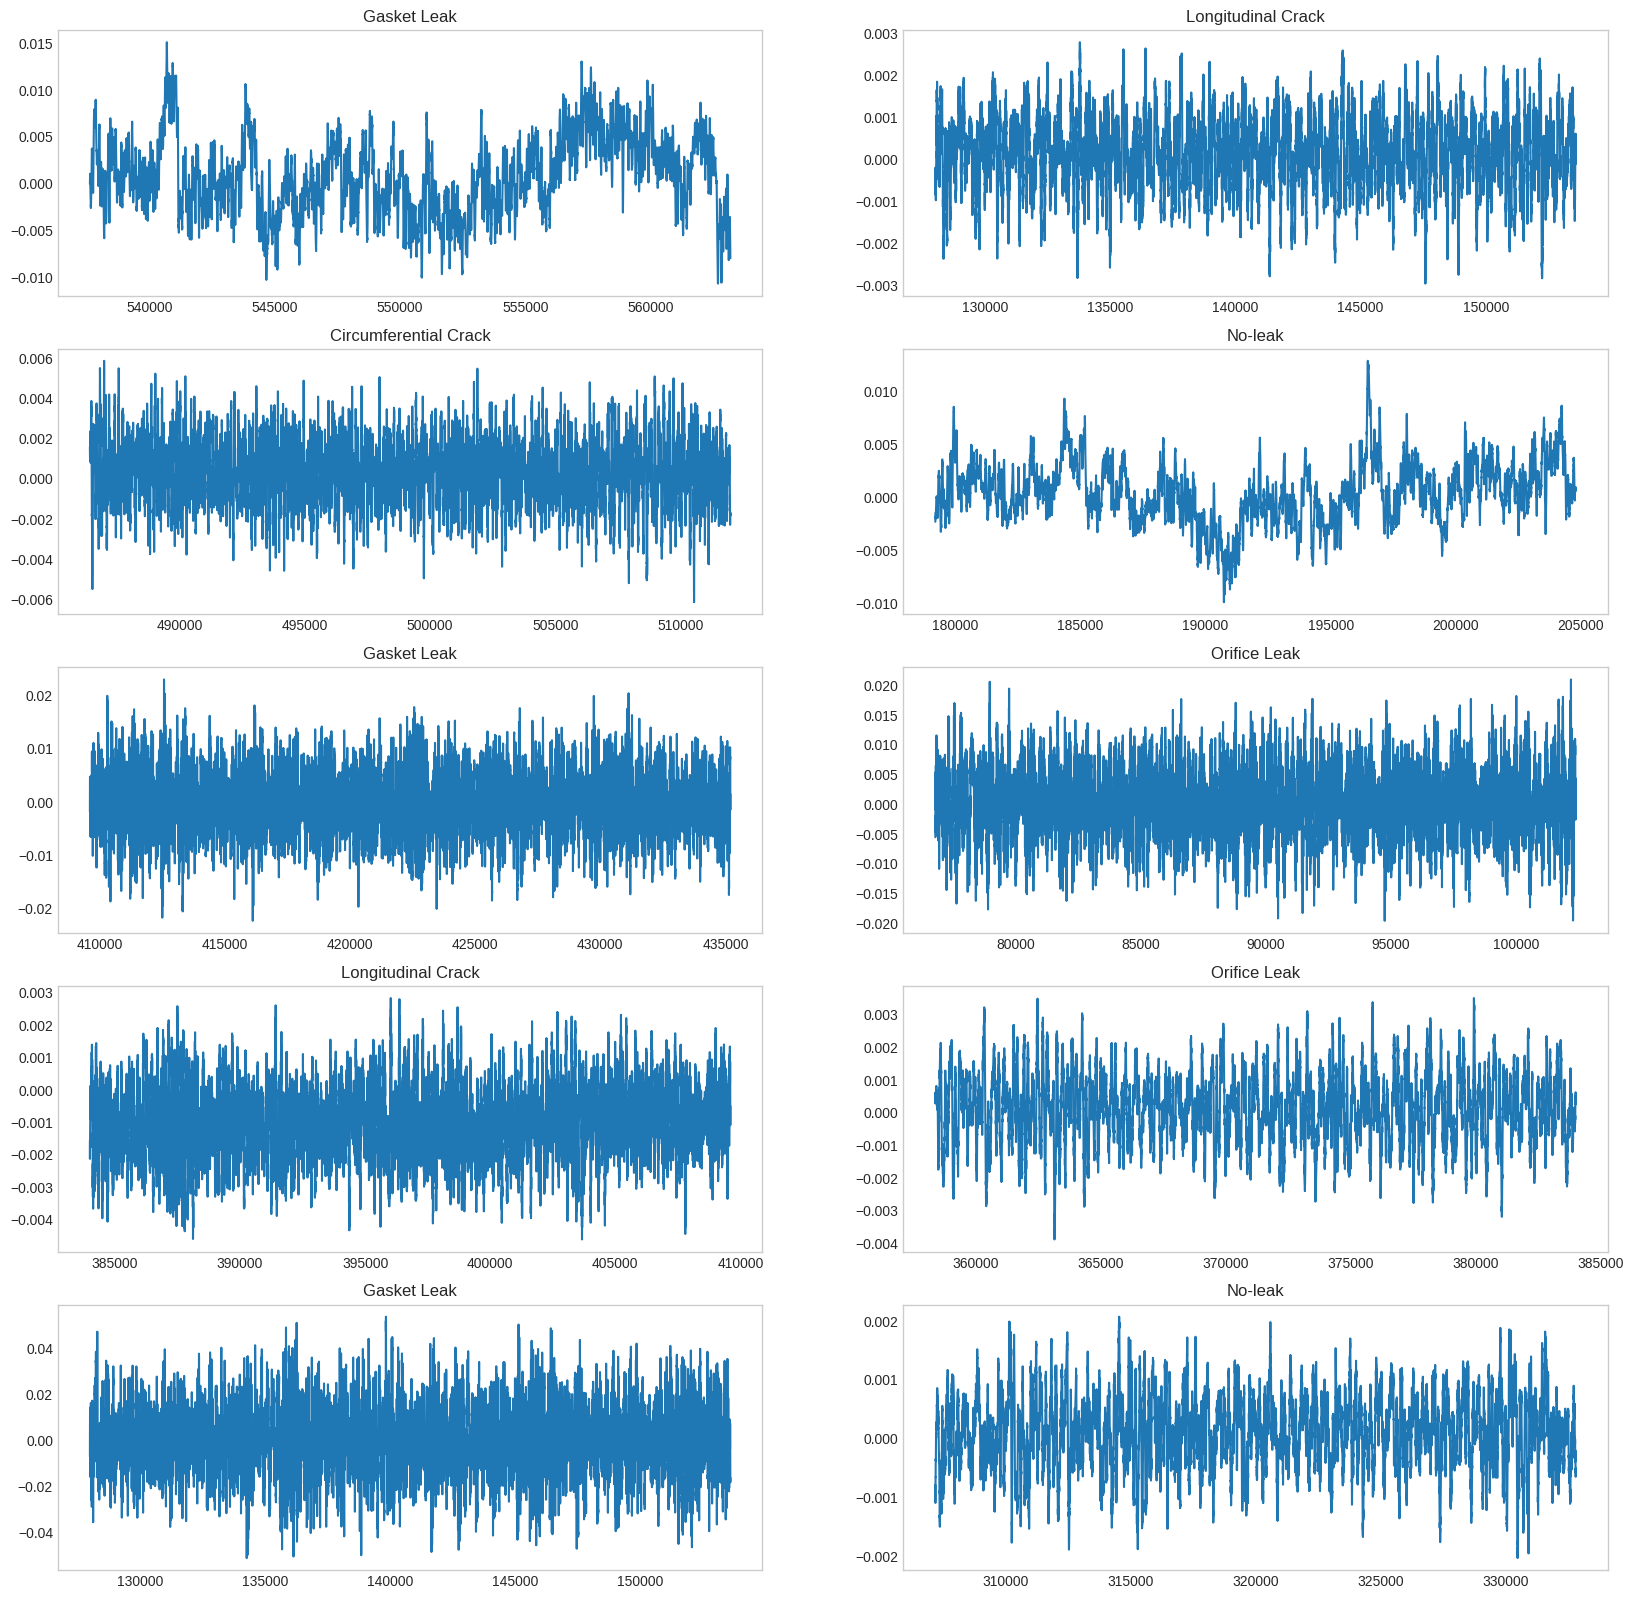

In [2]:
# Definir la ruta de los datos en Google Drive
data_dir = '/content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched'
original_sr = 25600  # Frecuencia de muestreo original en Hz
signal_sr = 25600  # Frecuencia de muestreo deseada en Hz
downsample_factor = original_sr // signal_sr

# Modo de clasificación: 'five_classes' o 'binary'
classification_mode = 'five_classes'  # Cambiar según necesidad

# Diccionario de etiquetas según el modo de clasificación
if classification_mode == 'five_classes':
    label_codes_dict = {
        'Circumferential Crack': 0,
        'Gasket Leak': 1,
        'Longitudinal Crack': 2,
        'No-leak': 3,
        'Orifice Leak': 4
    }
else:  # binary
    label_codes_dict = {'Leak': 0, 'No-leak': 1}

# Función para eliminar archivos .DS_Store si existen
def remove_DS_store_file(path):
    for ds_name in ['.DS_Store', '.DS_store']:
        ds_store_file_location = os.path.join(path, ds_name)
        if os.path.isfile(ds_store_file_location):
            os.remove(ds_store_file_location)

# Función para cargar datos de acelerómetro
def load_accelerometer_data(data_dir, sample_rate, downsample_factor, label_codes, mode='five_classes', fraction_to_include=1):
    remove_DS_store_file(data_dir)
    signals = []
    labels = []

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            print(f"Omitiendo {label_dir} porque no es un directorio")
            continue

        remove_DS_store_file(label_dir)

        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if not os.path.isfile(file_path):
                continue

            accelerometer_signal_df = pd.read_csv(file_path, index_col=False)
            accelerometer_signal_df = accelerometer_signal_df.iloc[::downsample_factor, :].reset_index(drop=True)
            accelerometer_signal = accelerometer_signal_df['Value'][0:(sample_rate * 30)]

            sample_indexes = np.linspace(0, len(accelerometer_signal) - sample_rate, len(accelerometer_signal) // sample_rate)
            signal_frames_number = fraction_to_include * len(sample_indexes)
            signal_frames_counter = 0

            for signal_frame in sample_indexes:
                accelerometer_signal_frame = accelerometer_signal[int(signal_frame):int(signal_frame + sample_rate)]
                signal_frames_counter += 1

                if signal_frames_counter > signal_frames_number:
                    break

                if len(accelerometer_signal_frame) != sample_rate:
                    continue

                if mode == 'five_classes':
                    signals.append(accelerometer_signal_frame)
                    labels.append(label_codes[label])
                else:  # binary
                    if label == 'No-leak':
                        signals.append(accelerometer_signal_frame)
                        labels.append(1)  # 1 para No-leak
                    else:
                        signals.append(accelerometer_signal_frame)
                        labels.append(0)  # 0 para Leak

    return signals, labels

# Cargar los datos desde Google Drive
signals_lst, labels_lst = load_accelerometer_data(
    data_dir,
    signal_sr,
    downsample_factor,
    label_codes_dict,
    mode=classification_mode,
    fraction_to_include=1
)

# Dividir los datos en conjuntos de entrenamiento y prueba
signals_dict = {'training': [], 'testing': []}
labels_dict = {'training': [], 'testing': []}

signals_dict['training'], signals_dict['testing'], labels_dict['training'], labels_dict['testing'] = train_test_split(
    signals_lst,
    labels_lst,
    test_size=0.2,
    random_state=53
)

# Imprimir información sobre el dataset
print(f'Data Directory: {data_dir}')
print(f'Sample Rate: {signal_sr} Hz')
print(f'Classification Mode: {classification_mode}')
print(f'Number of signals (training, testing): ({len(signals_dict["training"])}, {len(signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(signals_dict["training"][0])}')

# Visualizar algunas señales
plt.figure(figsize=(20, 20))
rows, cols = 5, 2
n = rows * cols
random_index = []

for i in range(n):
    plt.subplot(rows, cols, i + 1)
    random_index.append(np.random.randint(0, len(signals_dict['training'])))
    plt.plot(signals_dict['training'][random_index[i]])

    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()
plt.show()

# Normalization and Wavelet Denoising
Aplicación de técnicas de denoising basadas en wavelet para eliminar el ruido en las señales. Normalización posterior para preparar los datos para la generación de espectrogramas Mel.

Denoising training signals:   0%|          | 0/960 [00:00<?, ?it/s]

Denoising testing signals:   0%|          | 0/240 [00:00<?, ?it/s]

Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


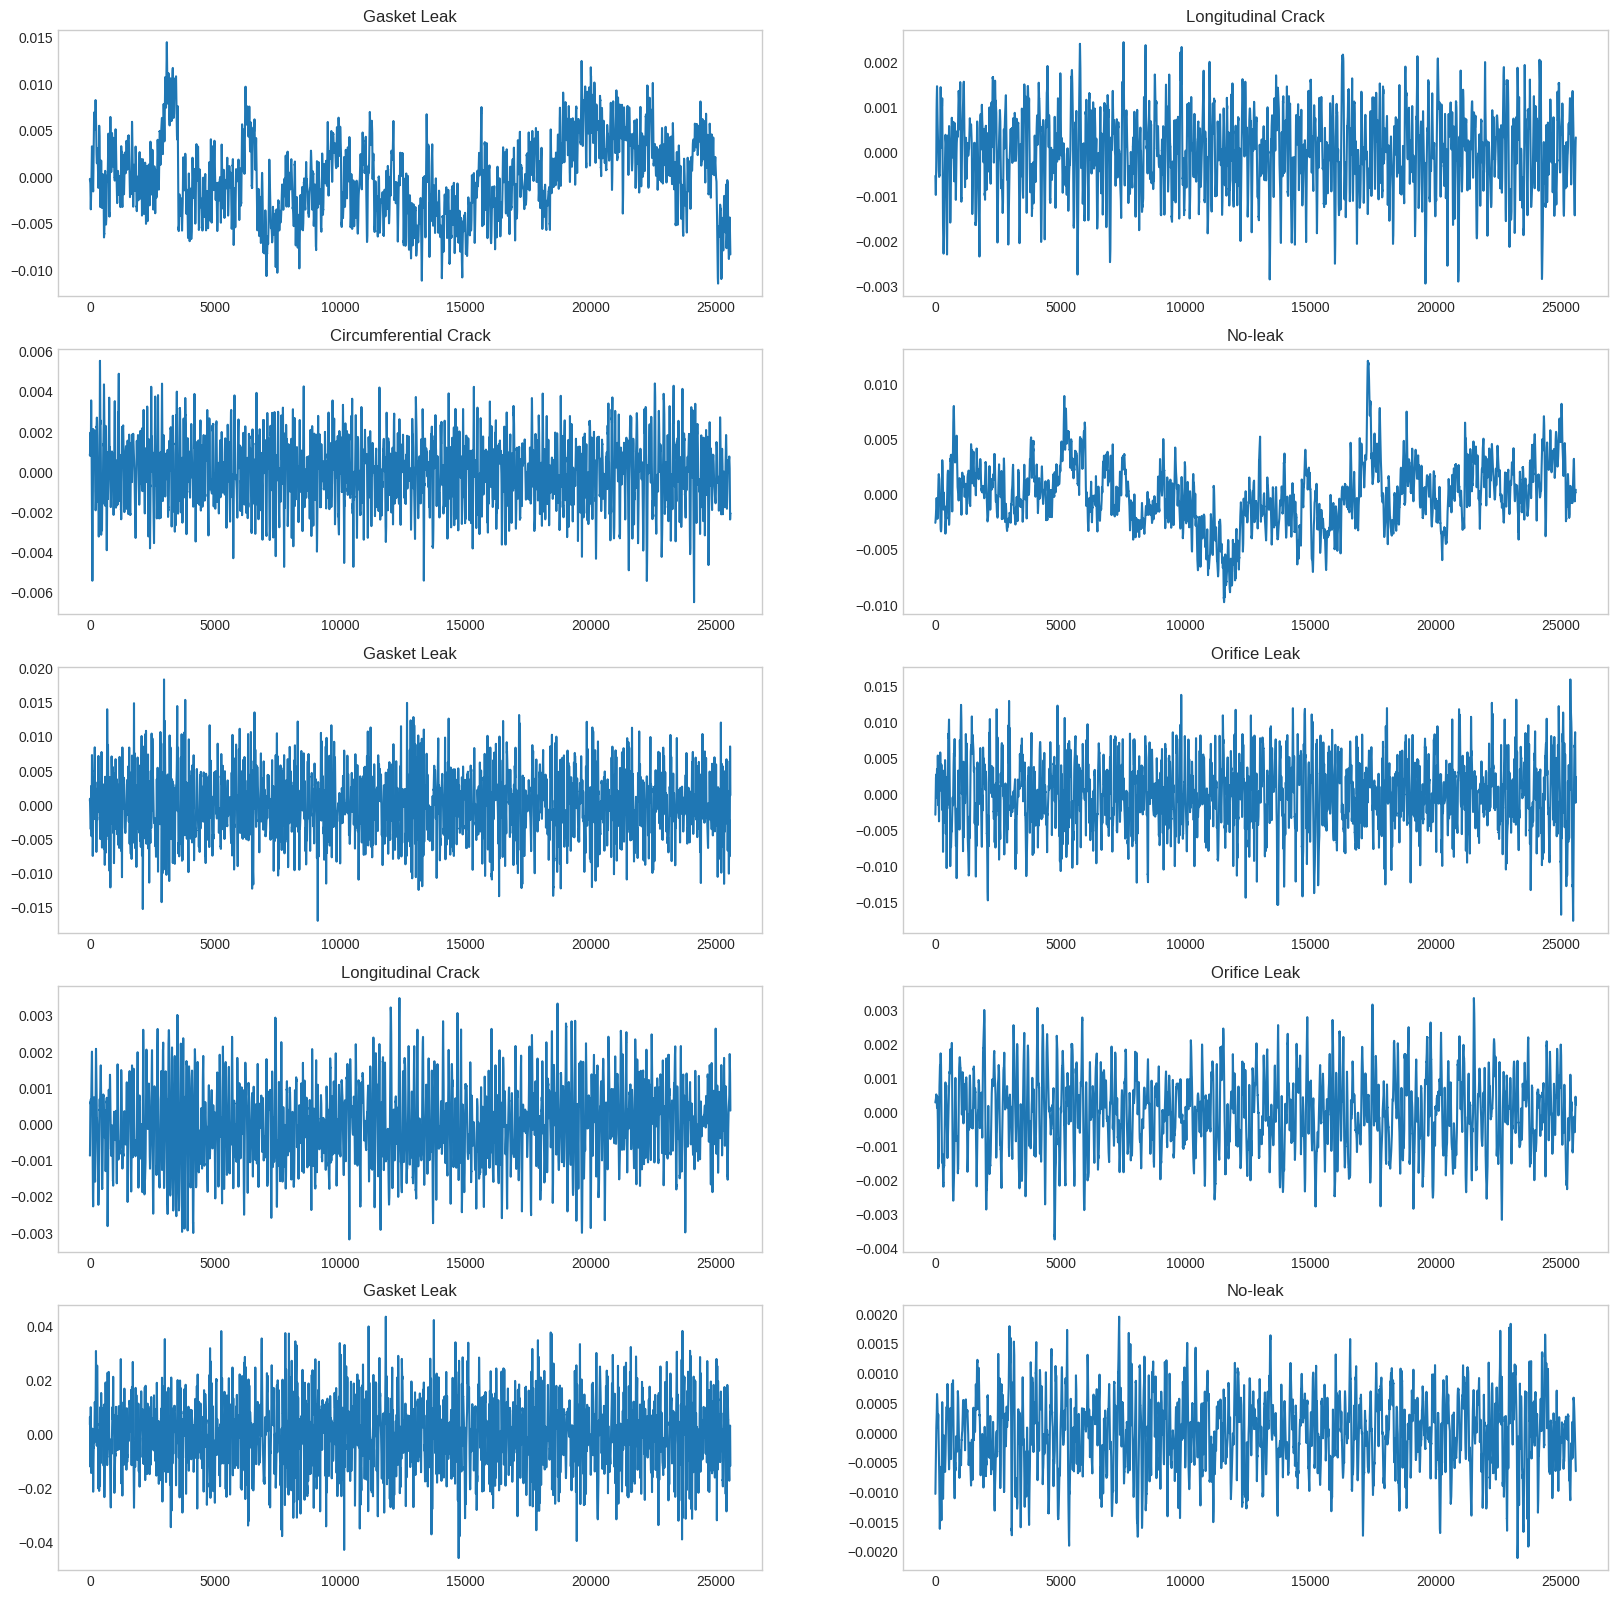

Normalizando señales procesadas con wavelet denoising...


Normalizando training signals:   0%|          | 0/960 [00:00<?, ?it/s]

Normalizando testing signals:   0%|          | 0/240 [00:00<?, ?it/s]

Number of signals (training, testing): (960, 240)
Number of samples per signal: 25600
Rango de valores en training: [0.0000, 1.0000]
Rango de valores en testing: [0.0000, 1.0000]


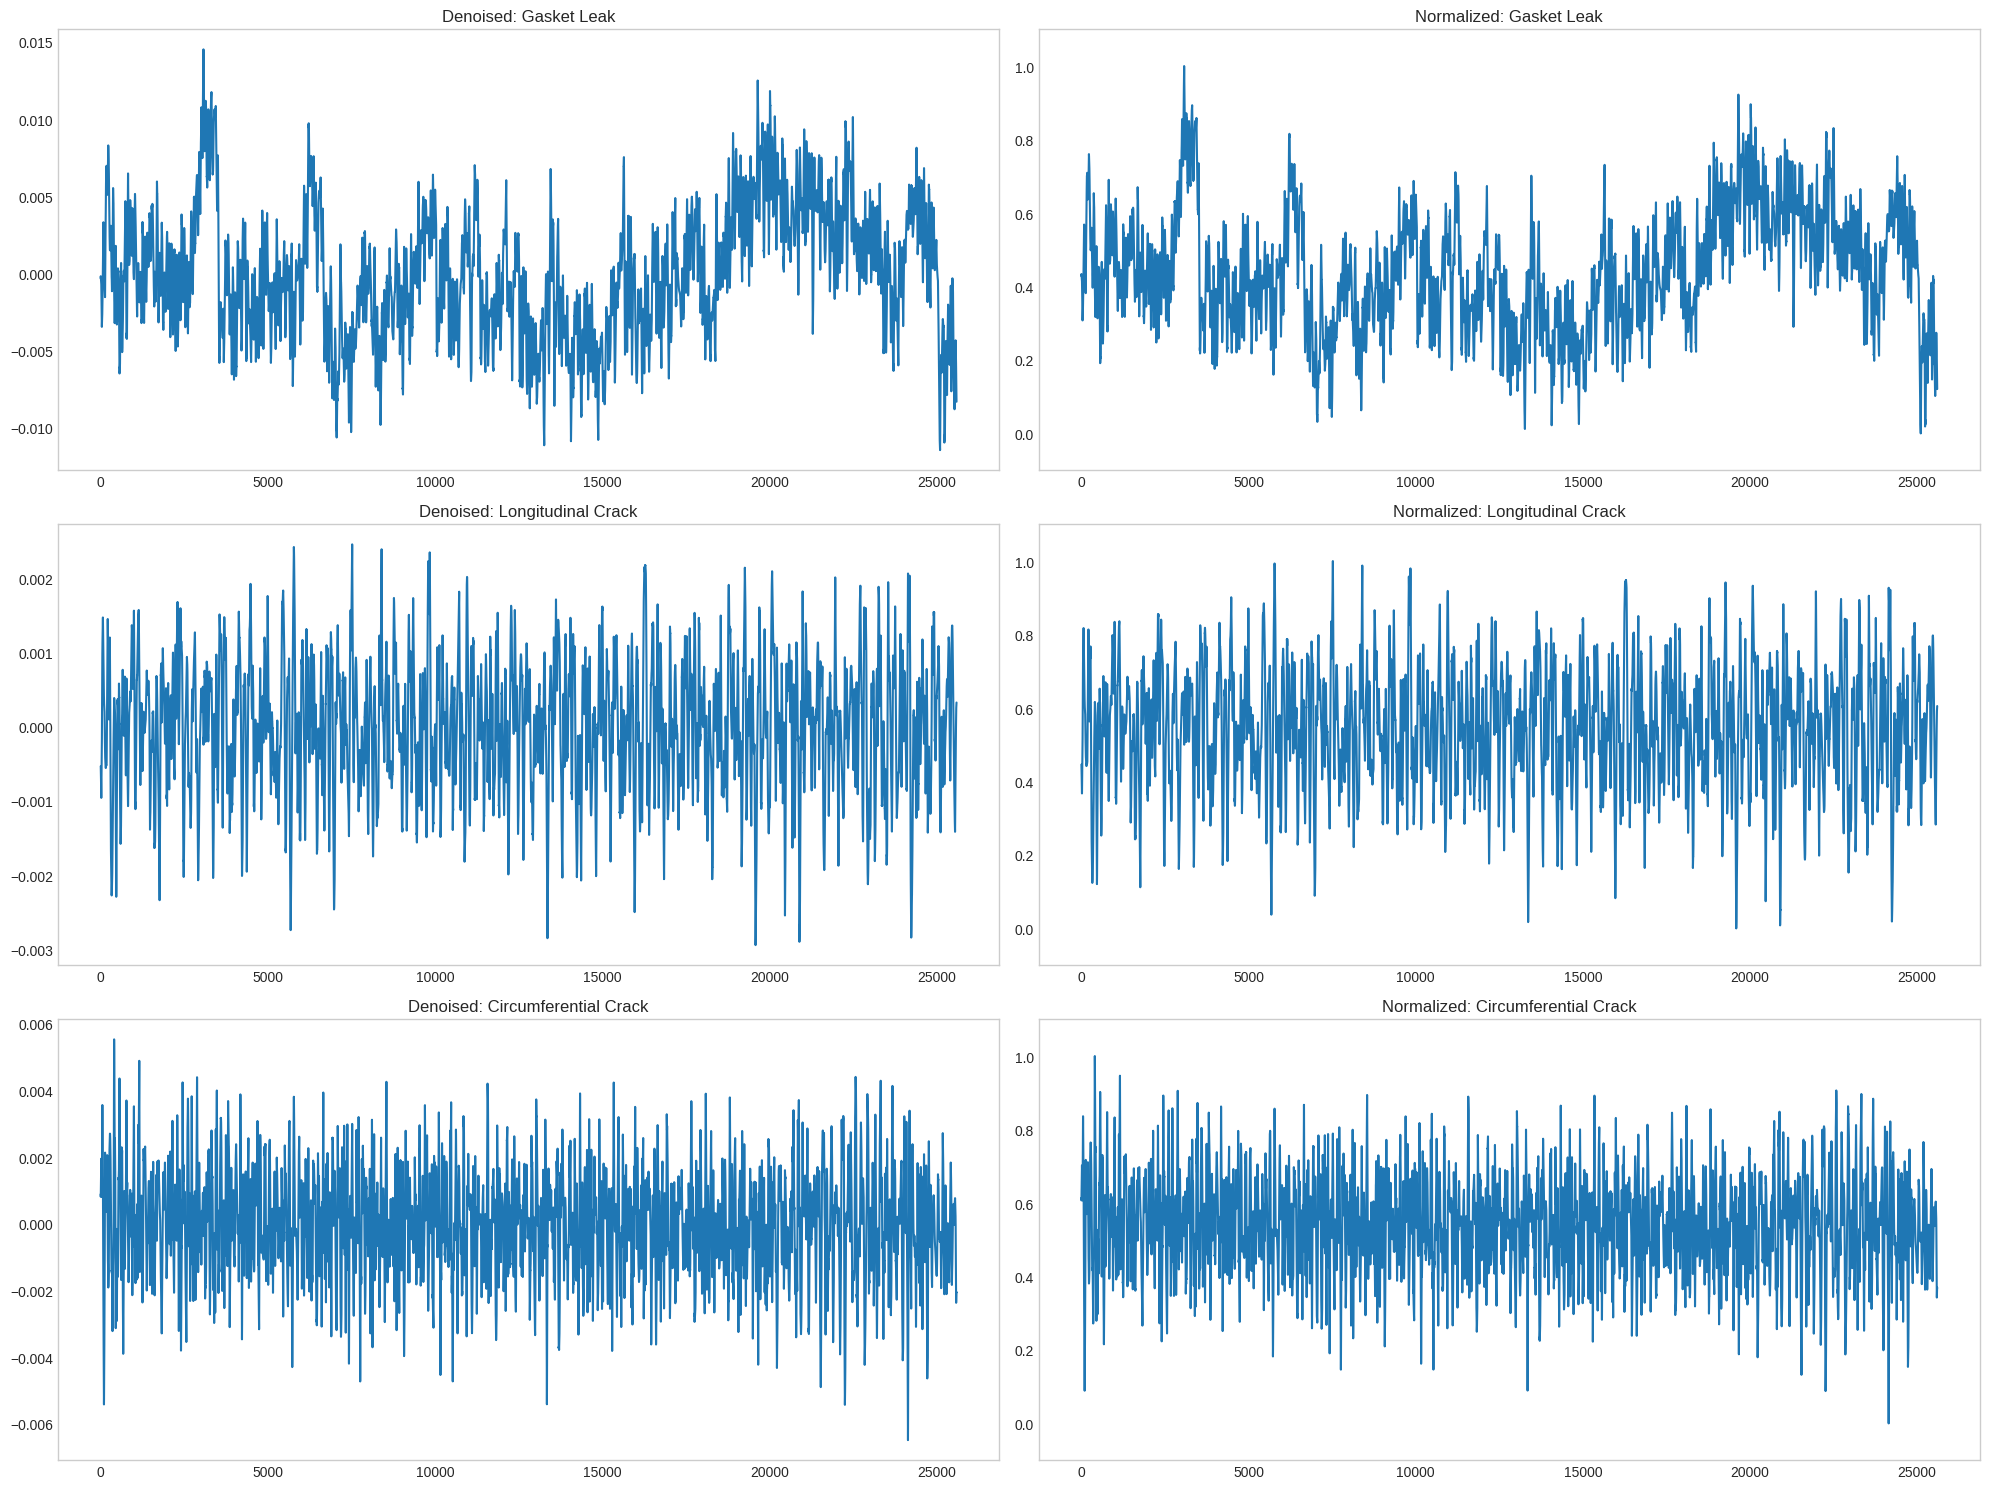

In [3]:
# Función para aplicar denoising con wavelet
def wavelet_denoise(signals_dict, labels_dict):
    """
    Normaliza y aplica denoising wavelet a las señales.

    Args:
        signals_dict: Diccionario con señales de entrenamiento y prueba.
        labels_dict: Diccionario con etiquetas de entrenamiento y prueba.

    Returns:
        wavelet_denoised_signals: Diccionario con señales procesadas.
        labels_dict: Diccionario con etiquetas.
    """
    # Crear un objeto de la clase WaveletDenoising
    wd = WaveletDenoising(
        normalize=True,
        wavelet='sym3',
        level=4,
        thr_mode='soft',
        method="universal"
    )

    # Crear un nuevo diccionario para almacenar las señales procesadas
    wavelet_denoised_signals = {'training': [], 'testing': []}

    for key, signals_subset in signals_dict.items():
        for signal_element in tqdm(signals_subset, desc=f"Denoising {key} signals"):
            # Aplicar denoising a la señal
            denoised_signal = wd.fit(signal_element)
            wavelet_denoised_signals[key].append(denoised_signal)

    return wavelet_denoised_signals, labels_dict

# Aplicar denoising a las señales
wavelet_denoised_signals_dict, labels_dict = wavelet_denoise(signals_dict=signals_dict, labels_dict=labels_dict)

# Imprimir información sobre el dataset resultante
print(f'Number of signals (training, testing): ({len(wavelet_denoised_signals_dict["training"])}, {len(wavelet_denoised_signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(wavelet_denoised_signals_dict["training"][0])}')

# Visualizar algunas señales procesadas
plt.figure(figsize=(20, 20))
rows, cols = 5, 2
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i + 1)
    plt.plot(wavelet_denoised_signals_dict['training'][random_index[i]])

    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()
plt.show()

# Función para normalizar señales
def normalize_signals(signals_dict):
    """
    Normaliza cada señal del diccionario a un rango de 0 a 1.

    Args:
        signals_dict: Diccionario con señales a normalizar.

    Returns:
        normalized_signals: Diccionario con señales normalizadas.
    """
    normalized_signals = {'training': [], 'testing': []}

    for key, signals_subset in signals_dict.items():
        for signal in tqdm(signals_subset, desc=f"Normalizando {key} signals"):
            min_val = np.min(signal)
            max_val = np.max(signal)

            if max_val > min_val:
                normalized_signal = (signal - min_val) / (max_val - min_val)
            else:
                normalized_signal = np.ones_like(signal) * 0.5

            normalized_signals[key].append(normalized_signal)

    return normalized_signals

# Normalizar las señales procesadas
print("Normalizando señales procesadas con wavelet denoising...")
normalized_signals_dict = normalize_signals(wavelet_denoised_signals_dict)

# Imprimir información sobre el dataset normalizado
print(f'Number of signals (training, testing): ({len(normalized_signals_dict["training"])}, {len(normalized_signals_dict["testing"])})')
print(f'Number of samples per signal: {len(normalized_signals_dict["training"][0])}')

# Comprobar rango de valores
for key in normalized_signals_dict:
    sample_signal = normalized_signals_dict[key][0]
    print(f"Rango de valores en {key}: [{np.min(sample_signal):.4f}, {np.max(sample_signal):.4f}]")

# Visualizar comparación de señales originales y normalizadas
plt.figure(figsize=(20, 15))
rows, cols = 3, 2
sample_indices = random_index[:3]

for i, idx in enumerate(sample_indices):
    # Señal con denoising (sin normalizar)
    plt.subplot(rows, cols, i * 2 + 1)
    plt.plot(wavelet_denoised_signals_dict['training'][idx])

    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][idx])]
    else:
        label_name = 'Leak' if labels_dict['training'][idx] == 0 else 'No-leak'

    plt.title(f"Denoised: {label_name}")
    plt.grid()

    # Señal normalizada entre 0 y 1
    plt.subplot(rows, cols, i * 2 + 2)
    plt.plot(normalized_signals_dict['training'][idx])
    plt.title(f"Normalized: {label_name}")
    plt.ylim([-0.1, 1.1])
    plt.grid()

plt.tight_layout()
plt.show()

# Usar las señales normalizadas para los pasos siguientes
wavelet_denoised_signals_dict = normalized_signals_dict

# Generate Mel-Log Spectrograms
Implementación del proceso de generación de espectrogramas logarítmicos de Mel usando STFT con 40 bancos de filtros. Cálculo de características estáticas, deltas y delta-deltas para crear una representación de 3 canales que capture tanto la información estática como dinámica de las señales.

Generating Mel-Log Spectrograms for training:   0%|          | 0/960 [00:00<?, ?it/s]

Generating Mel-Log Spectrograms for testing:   0%|          | 0/240 [00:00<?, ?it/s]

Number of Mel-Log Spectrograms (training, testing): (960, 240)
Mel-Log Spectrogram shape (example): (40, 101, 3)


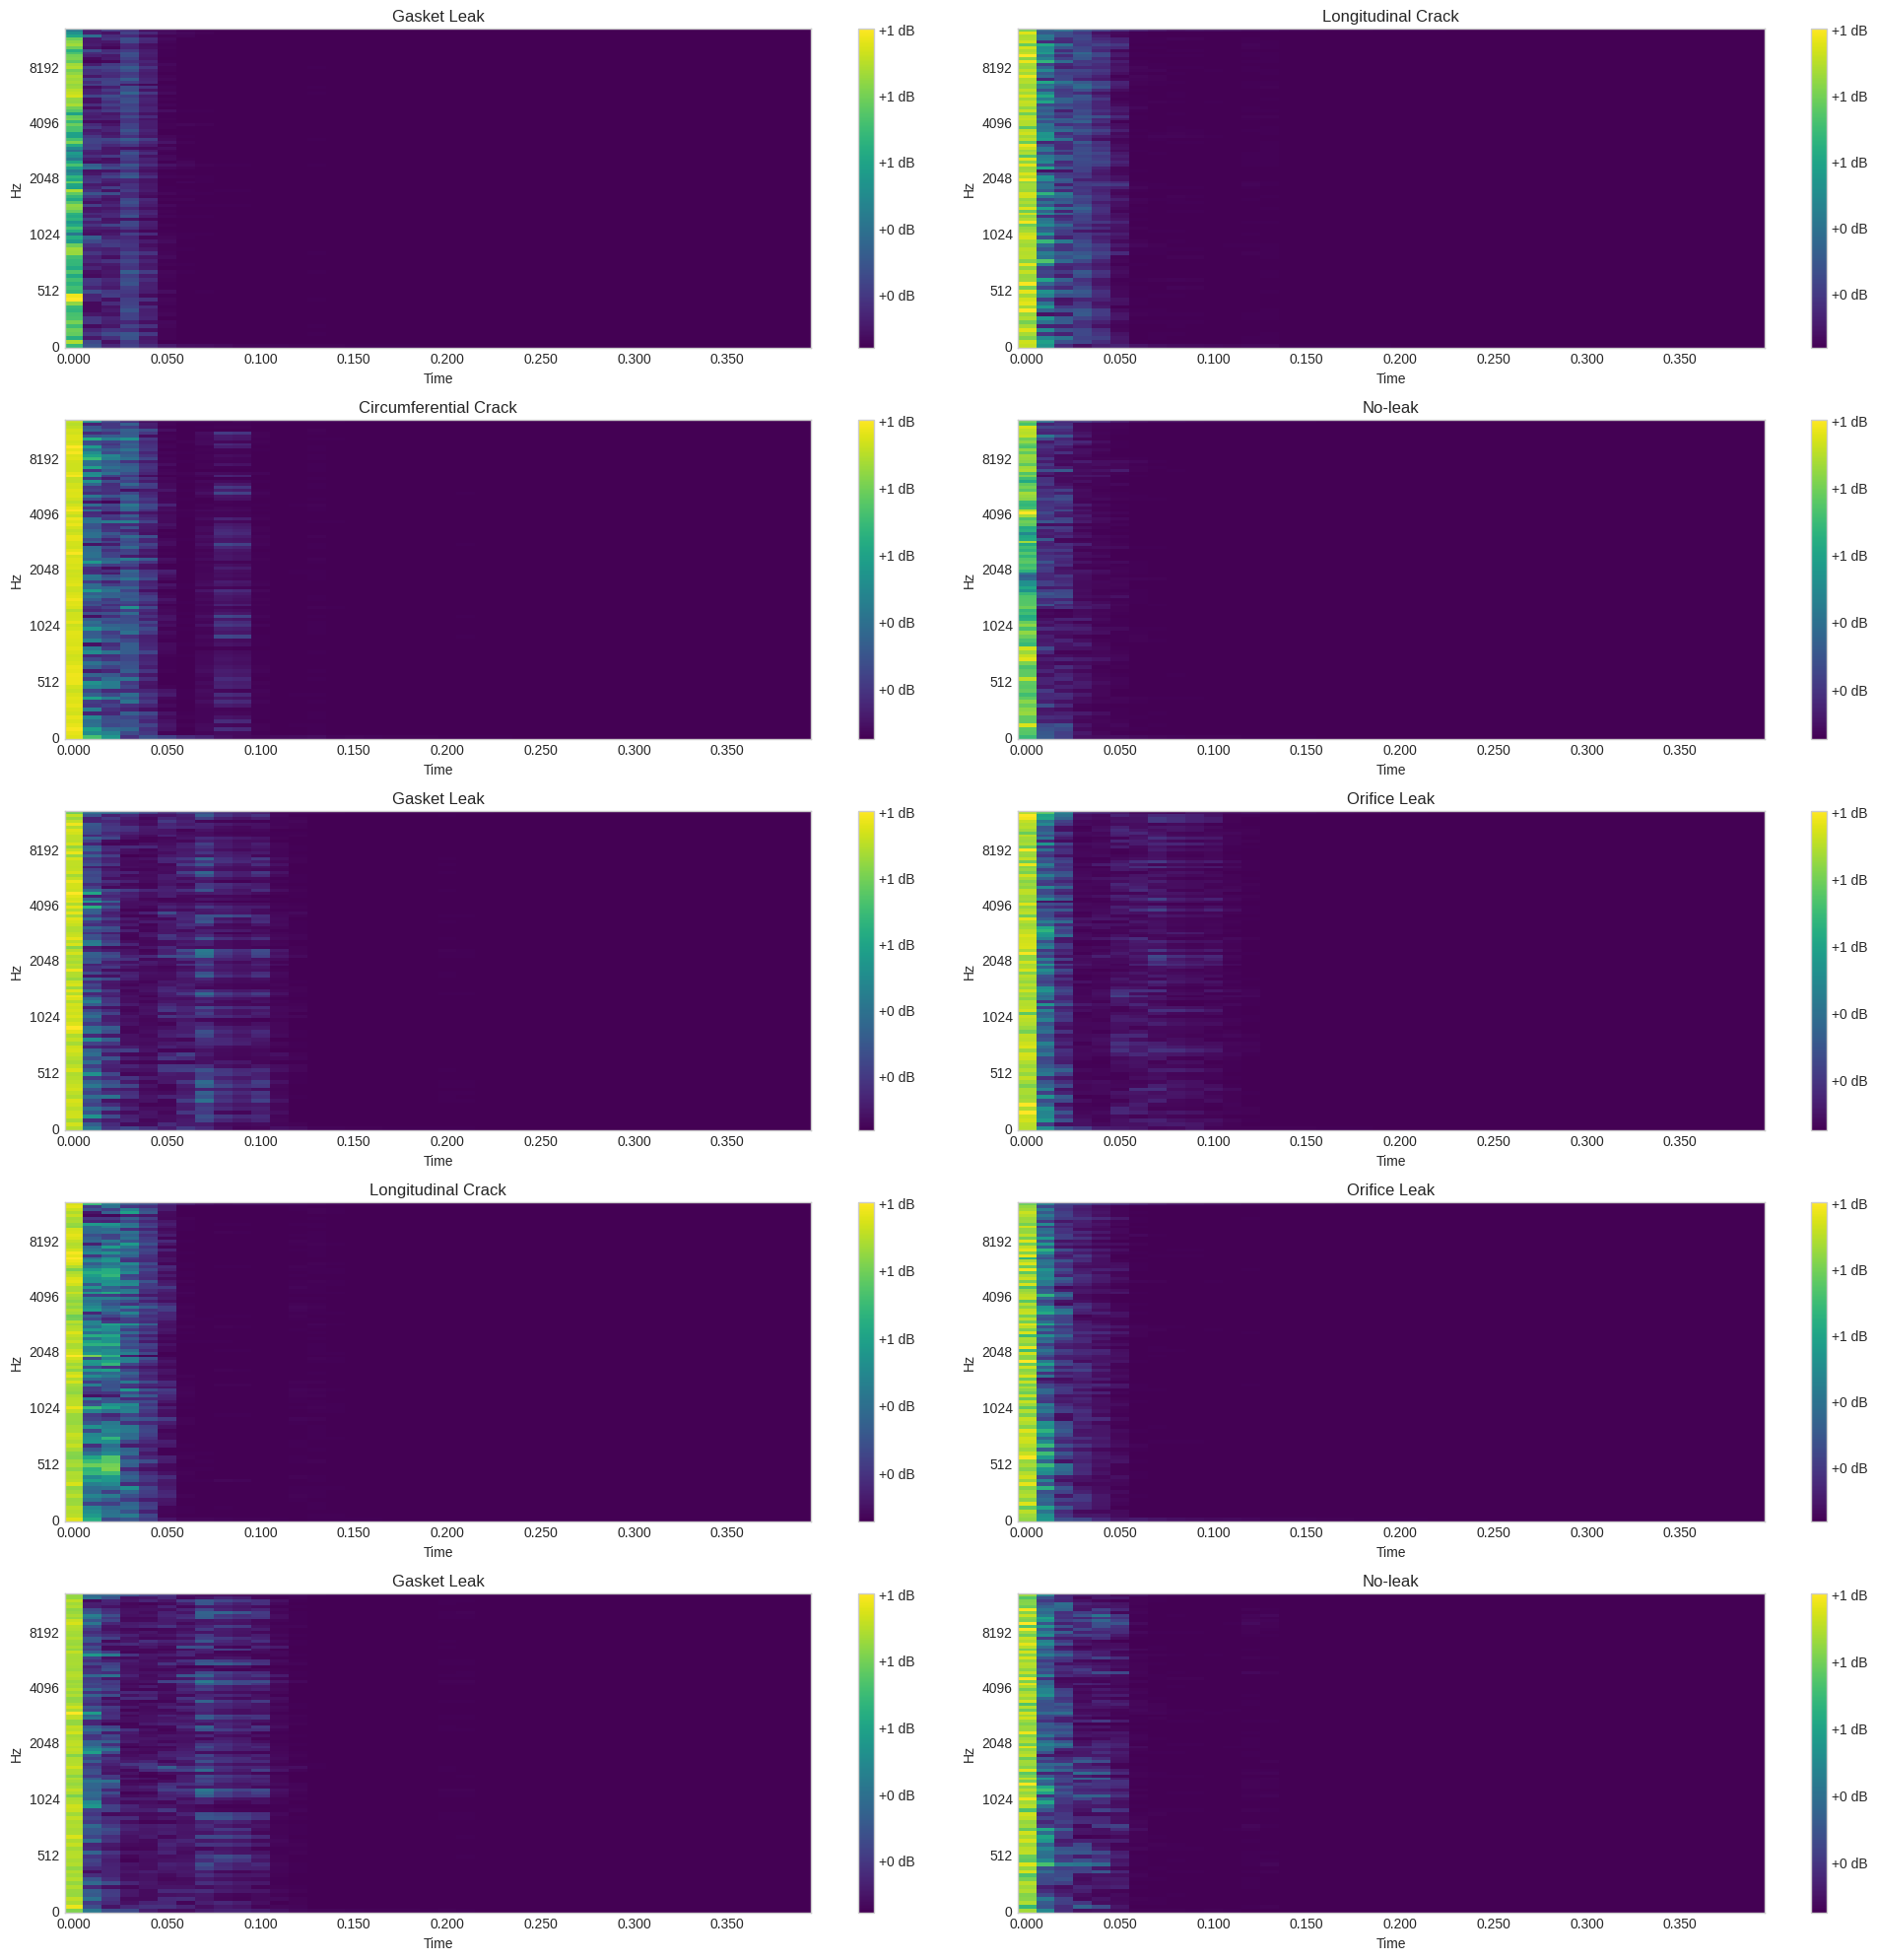

In [4]:
# Función para generar espectrogramas logarítmicos de Mel
def generate_mel_log_spectrograms(signals_dict, labels_dict, fs=25600, n_mels=40, fmin=1, fmax=12800):
    """
    Genera espectrogramas logarítmicos de Mel con características estáticas, deltas y delta-deltas.

    Args:
        signals_dict: Diccionario con señales de entrenamiento y prueba.
        labels_dict: Diccionario con etiquetas.
        fs: Frecuencia de muestreo en Hz.
        n_mels: Número de bancos de filtros Mel.
        fmin: Frecuencia mínima para los filtros Mel.
        fmax: Frecuencia máxima para los filtros Mel.

    Returns:
        mel_spectrograms_dict: Diccionario con espectrogramas logarítmicos de Mel.
        labels_dict: Diccionario con etiquetas.
    """
    # Parámetros para STFT
    frame_length = int(0.02 * fs)  # 20 ms
    frame_shift = int(0.01 * fs)  # 10 ms
    nfft = 512  # Tamaño de FFT

    # Crear diccionario para almacenar espectrogramas
    mel_spectrograms_dict = {'training': [], 'testing': []}

    for key, signals_subset in signals_dict.items():
        for i, signal in enumerate(tqdm(signals_subset, desc=f"Generating Mel-Log Spectrograms for {key}")):
            # Calcular STFT
            stft = librosa.stft(
                signal,
                n_fft=nfft,
                hop_length=frame_shift,
                win_length=frame_length,
                window='hann'
            )

            # Calcular espectrograma de potencia
            power_spectrogram = np.abs(stft) ** 2

            # Aplicar bancos de filtros Mel
            mel_filterbank = librosa.filters.mel(
                sr=fs,
                n_fft=nfft,
                n_mels=n_mels,
                fmin=fmin,
                fmax=fmax
            )
            mel_spectrogram = np.dot(mel_filterbank, power_spectrogram)

            # Convertir a escala logarítmica
            log_mel_spectrogram = np.log1p(mel_spectrogram)

            # Calcular deltas y delta-deltas
            delta = librosa.feature.delta(log_mel_spectrogram, order=1)
            delta_delta = librosa.feature.delta(log_mel_spectrogram, order=2)

            # Crear representación de 3 canales
            mel_3d = np.stack([log_mel_spectrogram, delta, delta_delta], axis=-1)

            # Normalizar a rango [0, 1]
            mel_3d = (mel_3d - np.min(mel_3d)) / (np.max(mel_3d) - np.min(mel_3d))

            # Almacenar en el diccionario
            mel_spectrograms_dict[key].append(mel_3d)

    return mel_spectrograms_dict, labels_dict

# Generar espectrogramas logarítmicos de Mel
mel_spectrograms_dict, labels_dict = generate_mel_log_spectrograms(
    wavelet_denoised_signals_dict,
    labels_dict,
    fs=signal_sr,
    n_mels=40,
    fmin=1,
    fmax=12800
)

# Imprimir información sobre los espectrogramas generados
print(f'Number of Mel-Log Spectrograms (training, testing): ({len(mel_spectrograms_dict["training"])}, {len(mel_spectrograms_dict["testing"])})')
print(f'Mel-Log Spectrogram shape (example): {mel_spectrograms_dict["training"][0].shape}')

# Visualizar algunos espectrogramas logarítmicos de Mel
plt.figure(figsize=(20, 20))
rows, cols = 5, 2
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i + 1)
    librosa.display.specshow(
        mel_spectrograms_dict['training'][random_index[i]][:, :, 0].T,
        sr=signal_sr,
        hop_length=int(0.01 * signal_sr),
        x_axis='time',
        y_axis='mel',
        fmin=1,
        fmax=12800,
        cmap='viridis'
    )
    plt.colorbar(format='%+2.0f dB')
    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'
    plt.title(label_name)

plt.tight_layout()
plt.show()

# Prepare Data for CNN Model
Preparación de los espectrogramas logarítmicos de Mel para ser utilizados en el modelo CNN. Conversión a arrays NumPy, normalización, expansión de dimensiones y codificación one-hot de las etiquetas. Guardado del dataset en formato HDF5.

In [5]:
def prepare_data_for_model(mel_spectrograms_dict, labels_dict, classification_mode):
    """
    Prepara los datos para el modelo CNN.

    Args:
        mel_spectrograms_dict: Diccionario con espectrogramas logarítmicos de Mel.
        labels_dict: Diccionario con etiquetas.
        classification_mode: Modo de clasificación ('five_classes' o 'binary').

    Returns:
        x_train, y_train, x_test, y_test: Datos preparados para entrenamiento.
        num_classes: Número de clases.
    """
    # Convertir a arrays numpy
    x_train = np.array(mel_spectrograms_dict['training'])
    y_train = np.array(labels_dict['training'])
    x_test = np.array(mel_spectrograms_dict['testing'])
    y_test = np.array(labels_dict['testing'])

    # Asegurar que los espectrogramas tengan valores normalizados
    x_train = np.clip(x_train, 0, 1)
    x_test = np.clip(x_test, 0, 1)

    # Determinar número de clases según el modo
    if classification_mode == 'five_classes':
        num_classes = 5
    else:  # binary
        num_classes = 2

    # One-hot encoding de las etiquetas
    y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
    y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

    return x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot, num_classes

# Preparar los datos para el modelo
x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot, num_classes = prepare_data_for_model(
    mel_spectrograms_dict,
    labels_dict,
    classification_mode
)

# Imprimir información sobre los datos preparados
print(f'x_train shape: {x_train.shape}')
print(f'y_train_onehot shape: {y_train_onehot.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test_onehot shape: {y_test_onehot.shape}')
print(f'Number of classes: {num_classes}')

# Guardar en formato HDF5
def save_dataset_to_h5(x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot,
                       classification_mode, num_classes, label_codes_dict,
                       file_path=None):
    """
    Guarda el dataset en formato HDF5.
    """
    if file_path is None:
        file_path = f'/content/drive/MyDrive/Tesis/Accelerometer_Dataset/mel_log_spectrogram_dataset_{classification_mode}.h5'

    print(f"Guardando dataset en {file_path}...")
    with h5py.File(file_path, 'w') as hf:
        # Crear grupos para training y testing
        train_group = hf.create_group('train')
        test_group = hf.create_group('test')

        # Guardar espectrogramas y etiquetas procesados
        train_group.create_dataset('spectrograms', data=x_train)
        train_group.create_dataset('labels', data=y_train)
        train_group.create_dataset('labels_onehot', data=y_train_onehot)

        test_group.create_dataset('spectrograms', data=x_test)
        test_group.create_dataset('labels', data=y_test)
        test_group.create_dataset('labels_onehot', data=y_test_onehot)

        # Guardar metadatos
        metadata = hf.create_group('metadata')
        metadata.create_dataset('num_classes', data=num_classes)
        metadata.create_dataset('shape', data=np.array(x_train.shape[1:]))
        metadata.attrs['classification_mode'] = classification_mode

        # Guardar diccionario de etiquetas
        import json
        if classification_mode == 'five_classes':
            label_codes_json = json.dumps({k: int(v) for k, v in label_codes_dict.items()})
        else:  # binary
            label_codes_json = json.dumps({k: int(v) for k, v in {'Leak': 0, 'No-leak': 1}.items()})
        metadata.attrs['label_codes_dict'] = label_codes_json

    print(f"Dataset procesado y guardado en {file_path}")
    print(f"Datos de entrenamiento: {len(x_train)} muestras")
    print(f"Datos de prueba: {len(x_test)} muestras")

    # Verificar la existencia del archivo guardado
    if os.path.exists(file_path):
        print(f"Archivo guardado correctamente. Tamaño: {os.path.getsize(file_path) / (1024*1024):.2f} MB")
    else:
        print("Error: No se pudo guardar el archivo")

# Guardar el dataset
save_dataset_to_h5(
    x_train, y_train, y_train_onehot,
    x_test, y_test, y_test_onehot,
    classification_mode, num_classes, label_codes_dict
)

x_train shape: (960, 40, 101, 3)
y_train_onehot shape: (960, 5)
x_test shape: (240, 40, 101, 3)
y_test_onehot shape: (240, 5)
Number of classes: 5
Guardando dataset en /content/drive/MyDrive/Tesis/Accelerometer_Dataset/mel_log_spectrogram_dataset_five_classes.h5...
Dataset procesado y guardado en /content/drive/MyDrive/Tesis/Accelerometer_Dataset/mel_log_spectrogram_dataset_five_classes.h5
Datos de entrenamiento: 960 muestras
Datos de prueba: 240 muestras
Archivo guardado correctamente. Tamaño: 111.03 MB


# Augment Spectrograms
Implementación de técnicas de aumento de datos para los espectrogramas, incluyendo desplazamiento de tiempo, enmascaramiento de frecuencia, ruido gaussiano y escalado de tiempo, para mejorar la generalización del modelo y combatir el sobreajuste.

In [6]:
def apply_spectrogram_augmentation(x_train, y_train, augmentation_factor=2):
    """
    Aplica técnicas de aumento de datos a los espectrogramas logarítmicos de Mel.

    Args:
        x_train: Espectrogramas de entrenamiento con forma (muestras, frecuencias, tiempo, canales).
        y_train: Etiquetas de entrenamiento.
        augmentation_factor: Número de veces que se aumentará el dataset original.

    Returns:
        augmented_x_train: Espectrogramas aumentados.
        augmented_y_train: Etiquetas correspondientes a los espectrogramas aumentados.
    """
    augmented_x_train = []
    augmented_y_train = []

    for i in tqdm(range(len(x_train)), desc="Augmenting spectrograms"):
        spectrogram = x_train[i].copy()
        label = y_train[i]

        # Agregar el espectrograma original
        augmented_x_train.append(spectrogram)
        augmented_y_train.append(label)

        for _ in range(augmentation_factor - 1):
            # Crear una copia para manipular
            augmented_spectrogram = spectrogram.copy()

            # Desplazamiento de tiempo
            time_shift = np.random.randint(-10, 10)
            augmented_spectrogram = np.roll(augmented_spectrogram, time_shift, axis=1)

            # Enmascaramiento de frecuencia
            freq_mask = np.random.randint(0, augmented_spectrogram.shape[0] // 4)
            freq_start = np.random.randint(0, augmented_spectrogram.shape[0] - freq_mask)
            augmented_spectrogram[freq_start:freq_start + freq_mask, :, :] = 0

            # Ruido gaussiano
            noise = np.random.normal(0, 0.01, augmented_spectrogram.shape)
            augmented_spectrogram += noise

            # Estiramiento/compresión simulada por canales independientes
            time_scale = np.random.uniform(0.9, 1.1)
            orig_len = augmented_spectrogram.shape[1]
            new_len = int(orig_len * time_scale)

            if new_len != orig_len:
                # Inicializar array para el espectrograma redimensionado
                resized_spectrogram = np.zeros_like(augmented_spectrogram)

                # Redimensionar cada canal independientemente
                for channel in range(augmented_spectrogram.shape[2]):
                    # Extraer el canal actual
                    channel_data = augmented_spectrogram[:, :, channel]

                    # Redimensionar este canal (2D)
                    resized_channel = cv2.resize(
                        channel_data,
                        (new_len, augmented_spectrogram.shape[0]),
                        interpolation=cv2.INTER_LINEAR
                    )

                    # Ajustar al tamaño original
                    if new_len > orig_len:
                        resized_spectrogram[:, :, channel] = resized_channel[:, :orig_len]
                    else:
                        resized_spectrogram[:, :new_len, channel] = resized_channel

                augmented_spectrogram = resized_spectrogram

            # Normalizar a rango [0, 1]
            augmented_spectrogram = np.clip(augmented_spectrogram, 0, 1)

            # Agregar el espectrograma aumentado
            augmented_x_train.append(augmented_spectrogram)
            augmented_y_train.append(label)

    return np.array(augmented_x_train), np.array(augmented_y_train)



Augmenting spectrograms:   0%|          | 0/960 [00:00<?, ?it/s]

Tamaño original: 960, Tamaño aumentado: 1920


# Implement and Train ResNet18 Model
Construcción de un modelo Log-PS-ResNet18 con regularización adaptado para trabajar con espectrogramas logarítmicos de Mel. Definición de bloques residuales y arquitectura general del modelo. Entrenamiento usando early stopping y reducción de learning rate.

Augmenting spectrograms:   0%|          | 0/768 [00:00<?, ?it/s]

Datos originales de entrenamiento: 768
Datos aumentados de entrenamiento: 1536
Datos de validación (sin aumentar): 192
Datos de prueba: 240


Model: "log_Mel_Spectrograms_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 40, 101, 3)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 20, 51, 64)     │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 20, 51, 64)     │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_17 (ReLU)           │ (None, 20, 51, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 10, 26, 64)     │              0 │ re_lu_17[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 10, 26, 64)     │         36,928 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 10, 26, 64)     │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_18 (ReLU)           │ (None, 10, 26, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 10, 26, 64)     │          4,160 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 10, 26, 64)     │         36,928 │ re_lu_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 10, 26, 64)     │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 10, 26, 64)     │            256 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 10, 26, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 10, 26, 64)     │              0 │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 10, 26, 64)     │         36,928 │ re_lu_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 10, 26, 64)     │            256 │ conv2d_25[0][0]        │
│ (BatchNormalization) 

 Total params: 11,460,549 (43.72 MB)

 Trainable params: 11,450,821 (43.68 MB)

 Non-trainable params: 9,728 (38.00 KB)

Epoch 1/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2032 - loss: 2.9091

96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 105ms/step - accuracy: 0.2031 - loss: 2.9089 - val_accuracy: 0.1927 - val_loss: 2.5656 - learning_rate: 1.0000e-06
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3192 - loss: 2.5818

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.3199 - loss: 2.5803 - val_accuracy: 0.1979 - val_loss: 2.9820 - learning_rate: 1.0080e-04
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5242 - loss: 2.1438 - val_accuracy: 0.1979 - val_loss: 2.9111 - learning_rate: 2.0060e-04
Epoch 4/200
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5921 - loss: 1.9588

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5919 - loss: 1.9594 - val_accuracy: 0.2865 - val_loss: 2.8908 - learning_rate: 3.0040e-04
Epoch 5/200
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6104 - loss: 1.9439

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6103 - loss: 1.9436 - val_accuracy: 0.3333 - val_loss: 2.8736 - learning_rate: 4.0020e-04
Epoch 6/200
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6640 - loss: 1.8106

96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6639 - loss: 1.8106 - val_accuracy: 0.4271 - val_loss: 3.1298 - learning_rate: 8.0040e-05
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7076 - loss: 1.6382

96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7079 - loss: 1.6375 - val_accuracy: 0.6354 - val_loss: 1.9699 - learning_rate: 8.0040e-05
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7933 - loss: 1.5009 - val_accuracy: 0.6250 - val_loss: 1.9189 - learning_rate: 8.0040e-05
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8466 - loss: 1.3475

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8465 - loss: 1.3476 - val_accuracy: 0.7604 - val_loss: 1.6898 - learning_rate: 8.0040e-05
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8111 - loss: 1.3929 - val_accuracy: 0.7500 - val_loss: 1.6279 - learning_rate: 8.0040e-05
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8804 - loss: 1.2821 - val_accuracy: 0.6615 - val_loss: 2.0477 - learning_rate: 8.0040e-05
Epoch 12/200
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8897 - loss: 1.2194

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8897 - loss: 1.2198 - val_accuracy: 0.7865 - val_loss: 1.5266 - learning_rate: 8.0040e-05
Epoch 13/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9074 - loss: 1.1556 - val_accuracy: 0.7083 - val_loss: 1.9863 - learning_rate: 8.0040e-05
Epoch 14/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9154 - loss: 1.1470 - val_accuracy: 0.5781 - val_loss: 2.3592 - learning_rate: 8.0040e-05
Epoch 15/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9050 - loss: 1.1602 - val_accuracy: 0.7656 - val_loss: 1.5080 - learning_rate: 8.0040e-05
Epoch 16/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9363 - loss: 1.0969 - val_accuracy: 0.7188 - val_loss: 1.7242 - learning_rate: 8.0040e-05
Epoch 17/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9577 - loss: 1.0315 - val_accuracy: 0.6667 - val_loss: 2.0516 - learning_rate: 8.0040e-05
Epoch 18/200
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9345

96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9345 - loss: 1.1372 - val_accuracy: 0.8021 - val_loss: 1.4741 - learning_rate: 8.0040e-05
Epoch 19/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9568 - loss: 1.0176 - val_accuracy: 0.7448 - val_loss: 1.7798 - learning_rate: 8.0040e-05
Epoch 20/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9705 - loss: 1.0037

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9704 - loss: 1.0038 - val_accuracy: 0.8125 - val_loss: 1.5402 - learning_rate: 8.0040e-05
Epoch 21/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9705 - loss: 0.9869 - val_accuracy: 0.7812 - val_loss: 1.8304 - learning_rate: 8.0040e-05
Epoch 22/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9635 - loss: 0.9870 - val_accuracy: 0.7083 - val_loss: 1.8700 - learning_rate: 8.0040e-05
Epoch 23/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9583 - loss: 1.0113 - val_accuracy: 0.6927 - val_loss: 2.1766 - learning_rate: 1.6008e-05
Epoch 24/200
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9839 - loss: 0.9477

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9840 - loss: 0.9476 - val_accuracy: 0.8333 - val_loss: 1.3978 - learning_rate: 1.6008e-05
Epoch 25/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9896 - loss: 0.9209 - val_accuracy: 0.8229 - val_loss: 1.3525 - learning_rate: 1.6008e-05
Epoch 26/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9962 - loss: 0.9073 - val_accuracy: 0.8333 - val_loss: 1.3539 - learning_rate: 1.6008e-05
Epoch 27/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9967 - loss: 0.8990 - val_accuracy: 0.8125 - val_loss: 1.3887 - learning_rate: 1.6008e-05
Epoch 28/200
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9977 - loss: 0.8914

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9976 - loss: 0.8914 - val_accuracy: 0.8385 - val_loss: 1.3145 - learning_rate: 1.6008e-05
Epoch 29/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9966 - loss: 0.8930 - val_accuracy: 0.8281 - val_loss: 1.3972 - learning_rate: 1.6008e-05
Epoch 30/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9973 - loss: 0.8917 - val_accuracy: 0.8281 - val_loss: 1.4007 - learning_rate: 1.6008e-05
Epoch 31/200
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.8865

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 1.0000 - loss: 0.8865 - val_accuracy: 0.8542 - val_loss: 1.3237 - learning_rate: 1.6008e-05
Epoch 32/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9969 - loss: 0.8873 - val_accuracy: 0.8333 - val_loss: 1.4141 - learning_rate: 1.6008e-05
Epoch 33/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9949 - loss: 0.8880 - val_accuracy: 0.8490 - val_loss: 1.3348 - learning_rate: 3.2016e-06
Epoch 34/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9975 - loss: 0.8873 - val_accuracy: 0.8542 - val_loss: 1.3239 - learning_rate: 3.2016e-06
Epoch 35/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9971 - loss: 0.8858 - val_accuracy: 0.8542 - val_loss: 1.3252 - learning_rate: 3.2016e-06
Epoch 36/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9996 - loss: 0.8803 - val_accuracy: 0.8542 - val_loss: 1.3282 - learning_rate: 3.2016e-06
Epoch 37/200
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9996

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9995 - loss: 0.8822 - val_accuracy: 0.8594 - val_loss: 1.3151 - learning_rate: 3.2016e-06
Epoch 38/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9988 - loss: 0.8812 - val_accuracy: 0.8542 - val_loss: 1.3134 - learning_rate: 3.2016e-06
Epoch 39/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9998 - loss: 0.8770 - val_accuracy: 0.8594 - val_loss: 1.3176 - learning_rate: 3.2016e-06
Epoch 40/200
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9928 - loss: 0.8877

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9929 - loss: 0.8876 - val_accuracy: 0.8698 - val_loss: 1.3166 - learning_rate: 3.2016e-06
Epoch 41/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9986 - loss: 0.8786 - val_accuracy: 0.8542 - val_loss: 1.3220 - learning_rate: 3.2016e-06
Epoch 42/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9972 - loss: 0.8821 - val_accuracy: 0.8490 - val_loss: 1.3488 - learning_rate: 3.2016e-06
Epoch 43/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9997 - loss: 0.8780 - val_accuracy: 0.8490 - val_loss: 1.3342 - learning_rate: 6.4032e-07
Epoch 44/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 1.0000 - loss: 0.8769 - val_accuracy: 0.8490 - val_loss: 1.3287 - learning_rate: 6.4032e-07
Epoch 45/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 1.0000 - loss: 0.8756 - val_accuracy: 0.8542 - val_loss: 1.3288 - learning_rate: 6.4032e-07
Epoch 46/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9979

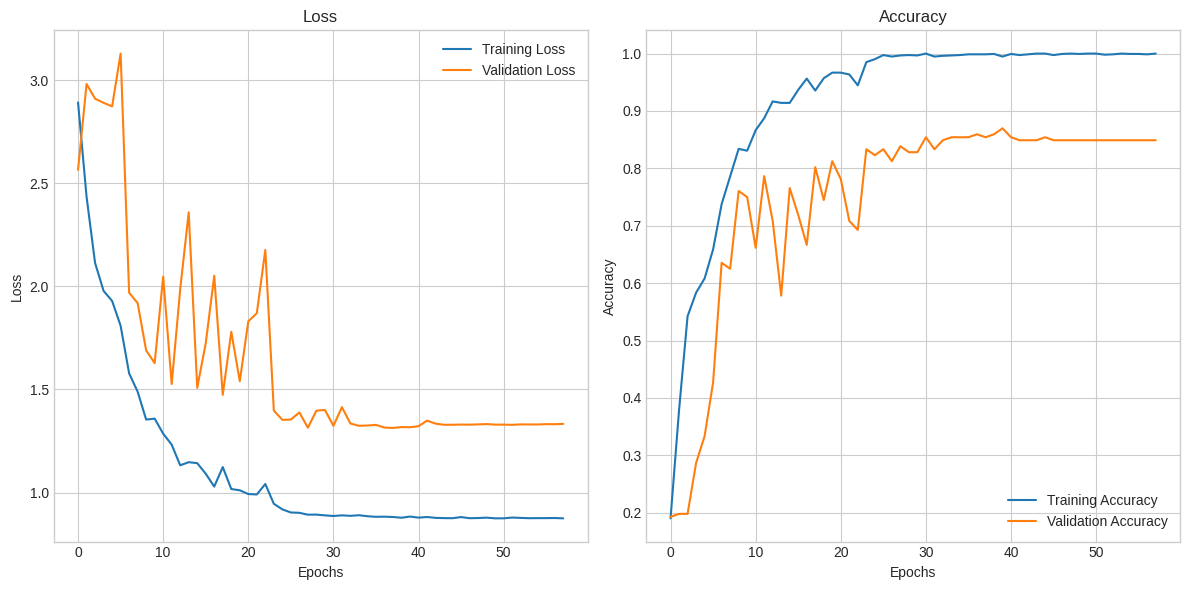

In [10]:
# Definición de bloques residuales y construcción del modelo Log-PS-ResNet18 con regularización
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, l2_reg=1e-4):
    """
    Bloque residual básico para ResNet con regularización L2.

    Args:
        x: Entrada al bloque residual.
        filters: Número de filtros para las capas convolucionales.
        kernel_size: Tamaño del kernel de las capas convolucionales.
        stride: Stride para la primera capa convolucional.
        conv_shortcut: Si True, aplica un atajo convolucional.
        l2_reg: Regularización L2.

    Returns:
        Salida del bloque residual.
    """
    shortcut = x

    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same',
                                 kernel_regularizer=regularizers.l2(l2_reg))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.ReLU()(x)

    return x

def build_log_ps_resnet18_with_regularization(input_shape, num_classes, l2_reg=1e-4, dropout_rate=0.5):
    """
    Versión mejorada con más regularización para combatir el overfitting
    """
    inputs = keras.Input(shape=input_shape)

    # Primera capa convolucional
    x = layers.Conv2D(64, 7, strides=2, padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Bloques residuales (sin cambios)
    x = residual_block(x, 64, conv_shortcut=True, l2_reg=l2_reg)
    x = residual_block(x, 64, l2_reg=l2_reg)

    x = residual_block(x, 128, stride=2, conv_shortcut=True, l2_reg=l2_reg)
    x = residual_block(x, 128, l2_reg=l2_reg)

    x = residual_block(x, 256, stride=2, conv_shortcut=True, l2_reg=l2_reg)
    x = residual_block(x, 256, l2_reg=l2_reg)

    x = residual_block(x, 512, stride=2, conv_shortcut=True, l2_reg=l2_reg)
    x = residual_block(x, 512, l2_reg=l2_reg)

    # Capa de clasificación con más regularización
    x = layers.GlobalAveragePooling2D()(x)

    # Aumentado dropout para reducir overfitting
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)  # Añadido dropout explícito

    outputs = layers.Dense(num_classes, activation='softmax',
                          kernel_regularizer=regularizers.l2(l2_reg))(x)

    model = keras.Model(inputs, outputs, name="log_Mel_Spectrograms_model")
    return model

from sklearn.model_selection import train_test_split

x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train,  # Datos originales sin aumentar
    y_train,  # Etiquetas originales sin aumentar
    test_size=0.2,
    stratify=y_train,
    random_state=42
)
# Aplicar aumento de datos a los espectrogramas de entrenamiento
augmented_x_train, augmented_y_train = apply_spectrogram_augmentation(x_train_split, y_train_split)

# 3. Ahora x_train_final son los datos aumentados, pero x_val permanece sin aumentar
x_train_final = augmented_x_train
y_train_final = augmented_y_train

# Verificar tamaños
print(f"Datos originales de entrenamiento: {len(x_train_split)}")
print(f"Datos aumentados de entrenamiento: {len(x_train_final)}")
print(f"Datos de validación (sin aumentar): {len(x_val)}")
print(f"Datos de prueba: {len(x_test)}")

# Construir el modelo
input_shape = x_train_final.shape[1:]  # Forma de entrada
num_classes=5
model = build_log_ps_resnet18_with_regularization(
    input_shape=input_shape,
    num_classes=num_classes,
    l2_reg=2e-4,  # Aumentado ligeramente
    dropout_rate=0.5  # Dropout explícito
)

# Compilar el modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model.summary()

# Callbacks mejorados
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=f'/content/drive/MyDrive/Tesis/Models/log_mel_spect_model.h5',
        monitor='val_accuracy',
        save_best_only=True
    )
]

# Solución: Usar el LearningRateScheduler estándar de Keras en lugar de una implementación personalizada
def warmup_schedule(epoch, lr):
    warmup_epochs = 5
    init_lr = 1e-6
    target_lr = 0.0005

    if epoch < warmup_epochs:
        return init_lr + (target_lr - init_lr) * epoch / warmup_epochs
    return lr

# Agregar el scheduler a los callbacks
callbacks.append(keras.callbacks.LearningRateScheduler(warmup_schedule))

# Entrenamiento del modelo
history = model.fit(
    x_train_final, keras.utils.to_categorical(y_train_final, num_classes),
    validation_data=(x_val, keras.utils.to_categorical(y_val)),
    epochs=200,
    batch_size=16,
    callbacks=callbacks
)

# Evaluación del modelo
test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot, verbose=2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Visualizar curvas de entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate Model Performance
Evaluación del modelo entrenado usando diferentes métricas como precisión, recall y F1-score. Visualización de la matriz de confusión y análisis de las predicciones para entender el comportamiento del modelo en los diferentes tipos de fugas.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<Figure size 1000x800 with 0 Axes>

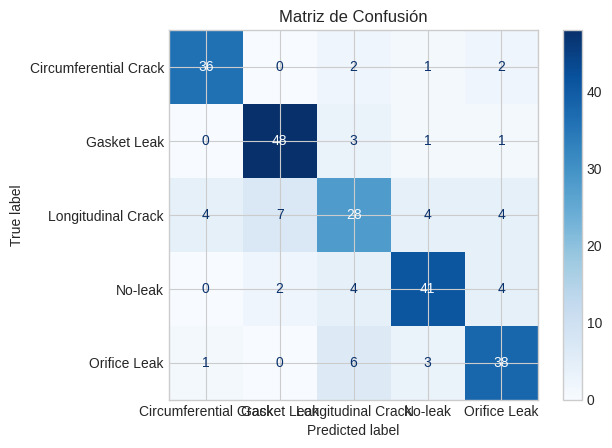

Reporte de Clasificación:
                       precision    recall  f1-score   support

Circumferential Crack       0.88      0.88      0.88        41
          Gasket Leak       0.84      0.91      0.87        53
   Longitudinal Crack       0.65      0.60      0.62        47
              No-leak       0.82      0.80      0.81        51
         Orifice Leak       0.78      0.79      0.78        48

             accuracy                           0.80       240
            macro avg       0.79      0.80      0.79       240
         weighted avg       0.79      0.80      0.79       240

Total de predicciones incorrectas: 49


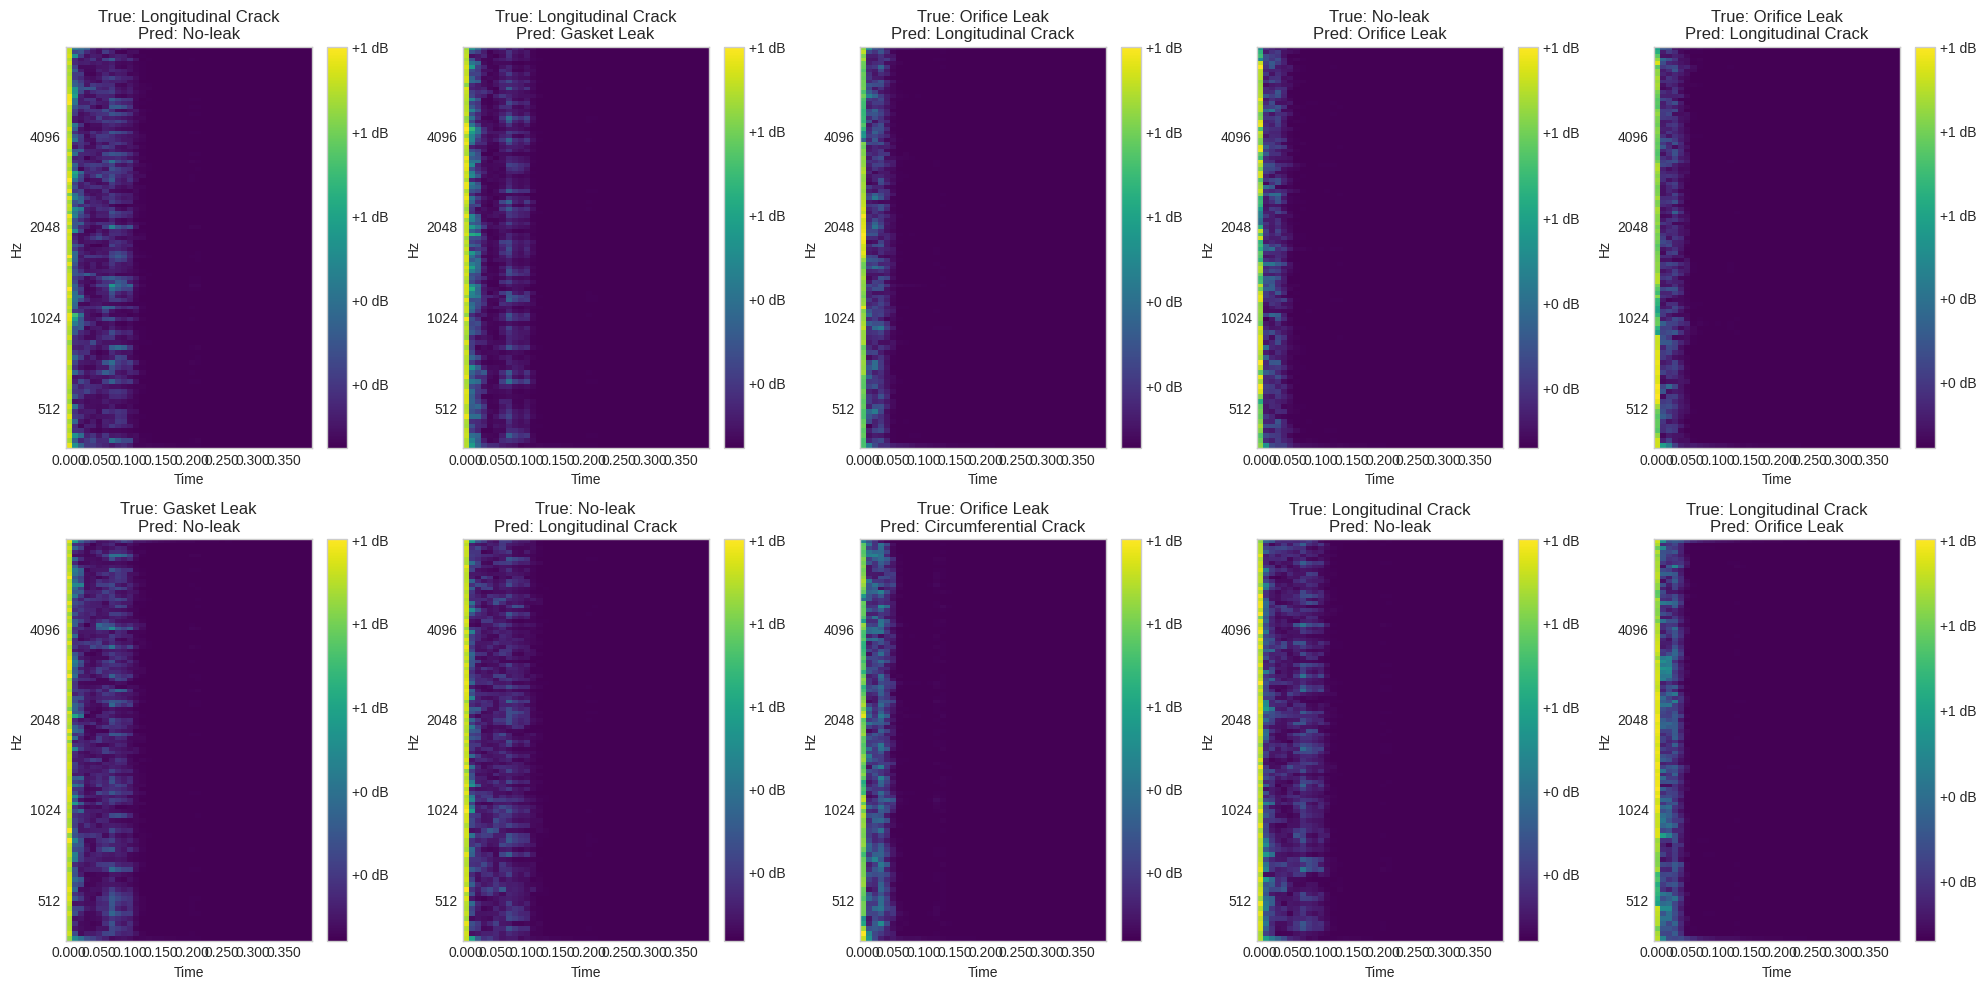

In [9]:
# Evaluación del modelo entrenado
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Predicciones del modelo
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_onehot, axis=1)

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Mostrar matriz de confusión
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(label_codes_dict.keys()))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Matriz de Confusión")
plt.show()

# Reporte de clasificación
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=list(label_codes_dict.keys()))
print("Reporte de Clasificación:")
print(classification_rep)

# Análisis de predicciones incorrectas
incorrect_indices = np.where(y_true_classes != y_pred_classes)[0]
print(f"Total de predicciones incorrectas: {len(incorrect_indices)}")

# Visualizar algunas predicciones incorrectas
if len(incorrect_indices) > 0:
    plt.figure(figsize=(20, 10))
    rows, cols = 2, 5
    for i, idx in enumerate(incorrect_indices[:rows * cols]):
        plt.subplot(rows, cols, i + 1)
        librosa.display.specshow(
            x_test[idx, :, :, 0].T,
            sr=signal_sr,
            hop_length=int(0.01 * signal_sr),
            x_axis='time',
            y_axis='mel',
            fmin=300,
            fmax=8000,
            cmap='viridis'
        )
        plt.colorbar(format='%+2.0f dB')
        true_label = list(label_codes_dict.keys())[y_true_classes[idx]]
        pred_label = list(label_codes_dict.keys())[y_pred_classes[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.tight_layout()
    plt.show()